In [2]:
import pandas as pd
from IPython.display import display
import os
import json
import spacy
from spacy.tokens import Doc
from spacy.lang.pt.examples import sentences 
from newspaper import Article, Source

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt 
from spacy.lang.pt.stop_words import STOP_WORDS

from fuzzywuzzy import fuzz
import re
from urllib.parse import urlparse, urlunparse

import requests
from bs4 import BeautifulSoup
import time

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

/Users/hannes_seidl/opt/anaconda3/envs/FDS_env/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [7]:
nlp = spacy.load('pt_core_news_sm') # commented out once it's loaded

punctuations = list(punctuation)

### Newspapers, stopwords, and words to filter out of keywords

In [8]:
# Newspapers to search

newsp = ['cmjornal.pt/', 
         'dn.pt/',
         'expresso.pt/',
         'folhanacional.pt/',
         'jn.pt/',
         'ionline.sapo.pt/',   
         'sol.sapo.pt/',
         'observador.pt/',
         'publico.pt/',
         'sabado.pt/',
         'sapo.pt/',
         'visao.pt/',
         ]

not_keywords = ["/multimedia", "/videos", 
                "/famosos", "/celebridades", 
                "/tecnologia", "/boa-vida", 
                "/tendencias", "/desporto",
                "/maissobre", "/ciencia",
                "/cinema", "/cultura",
                "/cidades", "/dinheiro",
                "/blogues", "/podcasts",
                "/vida", "/artes",
                "/iniciativas", "/colunistas/andre",
                "/tribuna"]

stop_words = {'comprida', 'lá', 'mesmo', 'ela', 'de', 'quero', 'vão', 'nesta', 'em', 'com',
              'tais', 'neste', 'obrigado', 'bom', 'for', 'vai', 'fazer', 'tens', 'alguns', 'todos',
              'tu', 'muito', 'estás', 'deve', 'novas', 'todo', 'foste', 'pode', 'pontos', 'pegar',
              'quieto', 'seria', 'eles', 'coisa', 'faz', 'sou', 'daquela', 'tua', 'suas', 'teu',
              'cuja', 'esses', 'vindo', 'aquele', 'um', 'certamente', 'essa', 'no', 'vens', 'também',
              'maiorias', 'fostes', 'tanta', 'elas', 'desse', 'diante', 'pelas', 'nove', 'quinta', 'maior',
              'do', 'quando', 'aqueles', 'desta', 'sabe', 'ambas', 'que', 'tentar', 'estes', 'próximo',
              'povo', 'sem', 'uns', 'tão', 'além', 'geral', 'porquanto', 'fora', 'vêm', 'tivemos',
              'depois', 'ir', 'ora', 'tarde', 'nessa', 'da', 'nós', 'ver', 'tiveram', 'tem',
              'cada', 'exemplo', 'número', 'meus', 'tuas', 'conhecido', 'cento', 'devem', 'para', 'fomos',
              'à', 'favor', 'quanto', 'teve', 'apenas', 'este', 'vais', 'mas', 'querem', 'lugar',
              'vinte', 'quê', 'após', 'apoio', 'mal', 'quarta', 'grande', 'adeus', 'pelos', 'parece',
              'dezanove', 'ligado', 'sob', 'estou', 'ao', 'final', 'talvez', 'demais', 'aos', 'agora',
              'você', 'nem', 'maioria', 'vez', 'treze', 'menor', 'temos', 'possível', 'ambos', 'não',
              'isto', 'dezoito', 'tempo', 'estas', 'área', 'nenhuma', 'fui', 'estará', 'cujo', 'faço',
              'bem', 'logo', 'quais', 'onde', 'menos', 'aquela', 'quatro', 'outras', 'pouca', 'dar',
              'dezasseis', 'último', 'valor', 'é', 'antes', 'aqui', 'mais', 'sétimo', 'dizem', 'estão',
              'veja', 'dezassete', 'ele', 'tivestes', 'tive', 'quarto', 'nova', 'bastante', 'pois', 'apoia',
              'outra', 'teus', 'caminho', 'fazeis', 'lado', 'somente', 'esteve', 'fazemos', 'nesse', 'dessa',
              'numa', 'qualquer', 'momento', 'assim', 'esse', 'boa', 'pôde', 'duas', 'longe', 'meio',
              'saber', 'és', 'ponto', 'daquele', 'estava', 'irá', 'perto', 'num', 'aí', 'umas',
              'nossas', 'falta', 'o', 'dão', 'quer', 'custa', 'tipo', 'sexto', 'vinda', 'segundo',
              'sétima', 'ter', 'seu', 'poder', 'enquanto', 'algo', 'sois', 'se', 'poderá', 'grandes',
              'naquele', 'dá', 'novos', 'tanto', 'cedo', 'vossas', 'cima', 'posição', 'era', 'na',
              'ser', 'vossos', 'seis', 'terceira', 'fim', 'onze', 'disso', 'tentei', 'iniciar', 'minha',
              'apontar', 'estiveram', 'quem', 'fará', 'até', 'sexta', 'zero', 'pouco', 'então', 'sei',
              'vossa', 'ainda', 'nuns', 'parte', 'sua', 'a', 'mês', 'acerca', 'terceiro', 'primeiro',
              'estar', 'oitava', 'grupo', 'porquê', 'contra', 'me', 'forma', 'dizer', 'sete', 'toda',
              'dois', 'portanto', 'estado', 'podia', 'vos', 'máximo', 'vocês', 'comprido', 'tenho', 'baixo',
              'somos', 'através', 'são', 'quinto', 'nada', 'segunda', 'outros', 'sempre', 'vosso', 'certeza',
              'debaixo', 'oitavo', 'lhe', 'dos', 'mil', 'têm', 'desde', 'nível', 'nos', 'usar',
              'primeira', 'fazes', 'fazia', 'tiveste', 'deste', 'corrente', 'oito', 'vós', 'doze', 'das',
              'sistema', 'inclusive', 'já', 'vem', 'contudo', 'minhas', 'cinco', 'estivestes', 'naquela', 'nas',
              'vários', 'tal', 'fazem', 'tentaram', 'posso', 'estiveste', 'direita', 'isso', 'embora', 'pela',
              'uma', 'breve', 'nossa', 'números', 'nossos', 'essas', 'dentro', 'deverá', 'partir', 'próxima',
              'eventual', 'conselho', 'às', 'esta', 'foi', 'só', 'te', 'possivelmente', 'obrigada', 'relação',
              'meses', 'três', 'põem', 'quieta', 'fez', 'ali', 'aquilo', 'sobre', 'qual', 'atrás',
              'estive', 'está', 'sim', 'estivemos', 'todas', 'cá', 'ou', 'muitos', 'porque', 'foram',
              'algumas', 'pelo', 'por', 'tente', 'questão', 'nosso', 'local', 'novo', 'nunca', 'como',
              'meu', 'tudo', 'porém', 'as', 'vezes', 'usa', 'os', 'diz', 'e', 'dez',
              'ademais', 'seus', 'conhecida', 'ontem', 'quinze', 'põe', 'des', 'entre', 'eu', 'catorze',
              'próprio', 'tendes', 'aquelas', 'podem', 'inicio', 'puderam', 'de o', 'correio', ' ', 'manhã',
              'a o', 'comentário', 'conteúdo', 'espaço', 'leitor', '', '”','“'}

In [6]:
def extract_data_from_json(folder_path):
    """
    Extracts 'url' and 'timestamp' from all JSON files in the specified folder and stores them in a DataFrame.
    
    :param folder_path: Path to the folder containing JSON files.
    :return: A pandas DataFrame with columns 'url' and 'timestamp'.
    """
    data = []

    # Iterate through all files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file is a JSON file
        if file_name.endswith('.json'):
            file_path = os.path.join(folder_path, file_name)
            # Open and load the JSON file
            with open(file_path, 'r', encoding='utf-8') as file:
                try:
                    json_data = json.load(file)
                    # Check if the data is a list of dictionaries
                    if isinstance(json_data, list):
                        for entry in json_data:
                            # Extract 'url' and 'timestamp' if available
                            if 'url' in entry and 'timestamp' in entry:
                                data.append({
                                    'url': entry['url'],
                                    'timestamp': entry['timestamp']
                                })
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON file {file_name}: {e}")

    # Convert collected data into a DataFrame
    df = pd.DataFrame(data, columns=['url', 'timestamp'])
    return df


In [42]:
df = extract_data_from_json("/Users/joaop.cardoso/MestradoCD/FCD/FDS_Project/cdx_results_json_files/data")

In [6]:
# Use this command to avoid running the code above
df = pd.read_csv('full_dataset.csv')

In [5]:
def filter_links(df, keywords):
    """
    Filters out rows from the DataFrame by assessing each keyword individually.
    Returns the result as a dictionary.
    
    :param df: A pandas DataFrame with at least 'url' and 'timestamp' columns.
    :param keywords: A list of keywords to filter out.
    :return: A dictionary with 'url' and 'timestamp' for rows that do not contain any of the keywords.
    """
    filtered_df = df.copy()

    # Iterate over each keyword and filter rows
    for keyword in keywords:
        filtered_df = filtered_df[~filtered_df['url'].str.contains(keyword, case=False, na=False)]
    
    # Convert the filtered DataFrame to a dictionary
    result_dict = pd.DataFrame(filtered_df)
    return result_dict


In [ ]:
# Removing all the unwanted links, by filtering out by tags in the links
df_clean = filter_links(df, not_keywords)

In [8]:
# Function to process the title
def title_input(df): 
    processed_texts = []  # Initialize inside the function

    # Extract the last part of each URL, handling NaN values
    last_part = df['url'].str.rsplit('/').str[-1]  # Extract the last part of the URL
    last_part = last_part.fillna("")  # Replace NaN values with an empty string

    # Handle cases where the last part is empty
    last_part[last_part == ""] = df['url'].str.rsplit('/').str[-2].fillna("")  # Use the second-to-last part if last is empty
    
    for part in last_part:
        if "-" in part:
            parts = part.rsplit('-')[0:-1]  # Split by '-' and remove the last element
            sentence = " ".join(parts)  # Join parts to form a sentence
            processed_sentence = nlp(sentence)  # Process with SpaCy
            processed_texts.append(" ".join(token.text for token in processed_sentence))
        else:
            processed_texts.append("")  # Append an empty string if no processing was done

    # Use .loc to avoid SettingWithCopyWarning
    df = df.copy()  # Create a copy to avoid SettingWithCopyWarning if df is a slice
    df.loc[:, 'processed_url_text'] = processed_texts

    # Update the original DataFrame dictionary with the filtered DataFrame
    df_updated = df
    
    return df

### Applying the function title_input to df_clean, in order to have the titles as strings for analysis

In [9]:
df_clean = title_input(df_clean)

In [11]:
# Function to find the newspaper name in the URL
def find_newspaper(url):
    for newspaper in newsp:
        if newspaper in url:
            return newspaper
    return None  # Return None if no newspaper is found

In [14]:
df_clean['newspaper'] = df_clean['url'].apply(find_newspaper)

In [17]:
df_clean.head()

,url,timestamp,processed_url_text,newspaper
0,https://www.cmjornal.pt/c-studio/especiais-c-s...,20200426174855,apoio domiciliario chega a 2200 pessoas por,cmjornal.pt/
1,https://www.cmjornal.pt/c-studio/especiais-c-s...,20200427174619,apoio domiciliario chega a 2200 pessoas por,cmjornal.pt/
2,https://www.cmjornal.pt/c-studio/especiais-c-s...,20200428171922,apoio domiciliario chega a 2200 pessoas por,cmjornal.pt/
3,https://www.cmjornal.pt/c-studio/especiais-c-s...,20200429172316,apoio domiciliario chega a 2200 pessoas por,cmjornal.pt/
4,https://www.cmjornal.pt/c-studio/especiais-c-s...,20200430181128,apoio domiciliario chega a 2200 pessoas por,cmjornal.pt/


### Function to create 'arquivo' links, to then store in specific columns

In [ ]:
def combine_url_and_timestamp(row):
    """
    Combines the base URL with the 'url' and 'timestamp' columns from a DataFrame row.
    
    :param row: A row from a pandas DataFrame.
    :return: A combined URL string.
    """
    base_url = "https://arquivo.pt/noFrame/replay/"
    return f"{base_url}{row['timestamp']}id_/{row['url']}"

In [19]:
df_clean['arquivo_url'] = df_clean.apply(combine_url_and_timestamp, axis=1)

In [ ]:
# Save the DataFrame to a CSV file, stored with arquivo link
df_clean.to_csv('full_ds_title_clean.csv', index=False, encoding='utf-8')

In [5]:
# Function to filter the dataframe, for links with "chega" and "andre ventura"
def filter_dataframe(df, text_column="processed_url_text"):
    # List to keep track of row indices that meet the criteria
    indices_to_keep = []

    # Iterate over each row in the DataFrame to access both the index and text
    for index, row in df.iterrows():
        text = row[text_column]
        
        # Skip if the text is NaN
        if pd.isna(text):
            continue
        
        doc = nlp(text)

        # Check if "chega" appears as a noun in the document
        is_chega_noun = any(token.text.lower() == "chega" and token.pos_ == "NOUN" for token in doc)

        # Check if both "andre" and "ventura" appear in the document
        contains_andre_ventura = "andre" in text.lower() and "ventura" in text.lower()

        # If either condition is met, keep the row index
        if is_chega_noun or contains_andre_ventura:
            indices_to_keep.append(index)

    # Filter the DataFrame to only include rows that meet the criteria
    df = df.loc[indices_to_keep].reset_index(drop=True)
    
    return df


### Applying the function to assess the stored title to distinguish between 'chega' noun and 'chega' verb

In [6]:
df_work = filter_dataframe(df_clean)

In [ ]:
# Save the DataFrame to a CSV file
df_work.to_csv('working_dataset.csv', index=False, encoding='utf-8')

In [ ]:
# Start from this point
df = pd.read_csv('working_dataset.csv')

### Functions to scrape links (url and arquivo url in case is needed) using newspaper package

In [61]:
# Function to scrape and parse an article
def scrape_article(row):
    """
    Fetches and parses the article content from the given URL.

    :param url: URL of the article.
    :return: A dictionary with the article's title, authors, publish date, and text.
    """
    article = Article(row['url'])
    article.download()  # Download the article content
    article.parse()     # Parse the downloaded content

    return {
        "title": article.title,
        "authors": article.authors,
        "publish_date": article.publish_date,
        "text": article.text
    }

#### Troubleshooting a link that is not read using newspaper package. Likely need to use beautiful soup in these cases

In [ ]:
# Function to scrape and parse an article
def scrape_article2(str):
    """
    Fetches and parses the article content from the given URL.

    :param url: URL of the article.
    :return: A dictionary with the article's title, authors, publish date, and text.
    """
    article = Article(str)
    article.download()  # Download the article content
    article.parse()     # Parse the downloaded content

    return {
        "title": article.title,
        "authors": article.authors,
        "publish_date": article.publish_date,
        "text": article.text
    }

[]


In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import requests
from urllib.parse import urlparse

def scrape_page_with_popup_optimized(row):
    url = row['arquivo_url']

    # Validate URL
    def is_valid_url(url):
        parsed = urlparse(url)
        return bool(parsed.netloc) and bool(parsed.scheme)

    if not is_valid_url(url):
        print(f"Invalid URL: {url}")
        return {'title': None, 'text': None}

    # Try using requests first
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'lxml')
            title_tag = soup.find("title")
            title_text = title_tag.get_text().strip() if title_tag else "No Title Found"
            paragraphs = soup.find_all("p")
            cat_text = "\n".join([p.get_text().strip() for p in paragraphs])
            return {'title': title_text, 'text': cat_text}
    except requests.exceptions.RequestException:
        print(f"Requests failed for URL: {url}, falling back to Selenium...")

    # Set up Selenium if requests fail
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--window-size=1920x1080")
    chrome_options.add_argument("--disable-extensions")
    chrome_options.add_argument("--disable-infobars")
    chrome_options.add_argument("--disable-notifications")
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")

    driver = None
    try:
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
        driver.get(url)
        
        # Wait for page readiness using JavaScript
        WebDriverWait(driver, 10).until(lambda d: driver.execute_script("return document.readyState") == "complete")

        # Handle popup (try multiple selectors)
        popup_selectors = [".popup-close-button", "#close-popup", ".modal-close"]
        for selector in popup_selectors:
            try:
                close_button = WebDriverWait(driver, 3).until(
                    EC.element_to_be_clickable((By.CSS_SELECTOR, selector))
                )
                close_button.click()
                print("Popup closed successfully.")
                break
            except Exception:
                continue

        # Get the HTML content
        html_content = driver.page_source
        soup = BeautifulSoup(html_content, 'lxml')

        # Extract title and paragraphs
        title_tag = soup.find("title")
        title_text = title_tag.get_text().strip() if title_tag else "No Title Found"
        paragraphs = soup.find_all("p")
        cat_text = "\n".join([p.get_text().strip() for p in paragraphs])

        return {'title': title_text, 'text': cat_text}

    except Exception as e:
        print(f"An error occurred while scraping URL: {url}. Error: {e}")
        return {'title': None, 'text': None}

    finally:
        if driver:
            driver.quit()


In [ ]:
def scrape_archive_page(row):
    """
    Fetches and parses content from an archived web page, ensuring the final archived URL is used.
    
    :param url: URL of the archived page.
    :param timestamp: Timestamp of the archived URL (from the Arquivo.pt dataset).
    :return: A dictionary with the article's title, authors, publish date, and text.
    """
    try:
        # Set up Selenium WebDriver
        options = webdriver.ChromeOptions()
        options.add_argument("--headless")  # Run in headless mode (no GUI)
        options.add_argument("--disable-gpu")  # Disable GPU for performance
        options.add_argument("--no-sandbox")  # Required for some server environments
        options.add_argument("--blink-settings=imagesEnabled=false")  # Disable images
        options.page_load_strategy = "eager"  # Stop loading after DOMContentLoaded

        driver = webdriver.Chrome(options=options)
        driver.set_page_load_timeout(15)  # Increase page load timeout to 30 seconds

        # Load the initial URL
        driver.get(row)

        # Wait for the page to load fully
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.TAG_NAME, "body"))  # Wait up to 20 seconds
        )

        # Get the final archived URL after all redirects
        final_archived_url = driver.current_url
        print(f"Final archived URL: {final_archived_url}")

        # If the final URL points to a live site, reconstruct the Arquivo.pt link
        if "arquivo.pt" not in final_archived_url:
            final_archived_url = f"https://arquivo.pt/noFrame/replay/{row['timestamp']}/{final_archived_url}"
            print(f"Reconstructed archived URL: {final_archived_url}")

        # Close the driver
        driver.quit()

        # Use newspaper3k to extract content from the reconstructed archived URL
        article = Article(final_archived_url)
        article.download()  # Download content from the final archived URL
        article.parse()  # Parse the downloaded content

        return {
            "title": article.title,
            "authors": article.authors,
            "publish_date": article.publish_date,
            "text": article.text
        }
    except Exception as e:
        print(f"Error processing URL {url}: {e}")
        return {
            "title": None,
            "authors": None,
            "publish_date": None,
            "text": None
        }

### Function using the article and arquivo link, and organized to avoid scraping the same article multiple times

In [ ]:
def scrape_with_duplicates_handling(df):
    """
    Scrapes data from a dataset while avoiding duplicates.
    If a row is processed successfully, subsequent duplicates are skipped.
    
    :param df: Input dataframe with 'url' and other necessary columns.
    :return: A new dataframe with the scraped data.
    """
    processed_urls = set()  # To track processed URLs
    results = []  # To store the scraped results
    
    for _, row in df.iterrows():
        url = row['url']  # Extract the URL from the current row
        
        if url in processed_urls:
            print(f"Skipping duplicate URL: {url}")
            continue  # Skip duplicates
        
        # Attempt to scrape the data
        try:
            scraped_data = scrape_article(row)  # Try live article scraping
            if not scraped_data['title']:  # If scrape_article fails to retrieve meaningful data
                raise ValueError("Empty title from scrape_article")
        except Exception as e:
            print(f"scrape_article failed for URL {url}: {e}")
            try:
                scraped_data = scrape_archive_page(row)  # Fall back to archived page scraping
            except Exception as archive_error:
                print(f"scrape_archive_page also failed for URL {url}: {archive_error}")
                scraped_data = {
                    "title": None,
                    "authors": None,
                    "publish_date": None,
                    "text": None
                }
        
        # If scraping succeeds, add URL to processed and save data
        processed_urls.add(url)
        results.append({**row.to_dict(), **scraped_data})  # Combine original row with scraped data
    
    # Create a new dataframe with the results
    return pd.DataFrame(results)

In [ ]:
# Apply the function to the dataset
new_df = scrape_with_duplicates_handling(df)

# Save the new dataset to a file (optional)
new_df.to_csv("scraped_data.csv", index=False)

scraped_df = new_df = pd.read_csv('scraped_data.csv')

scraped_df.head()

,url,timestamp,processed_url_text,newspaper,arquivo_url,title,authors,publish_date,text
0,https://www.cmjornal.pt/politica/amp/andre-ven...,20200124190851,andre ventura do chega quer camaras nas fardas...,cmjornal.pt/,https://arquivo.pt/wayback/20200124190851/http...,André Ventura do Chega quer câmaras nas fardas...,[],NaN,O partido Chega apresentou um projeto de resol...
1,https://www.cmjornal.pt/politica/amp/aprovada-...,20200203181044,aprovada proposta do chega para divulgar finan...,cmjornal.pt/,https://arquivo.pt/wayback/20200203181044/http...,Aprovada proposta do Chega para divulgar finan...,[],NaN,A proposta do Chega para que seja pública a li...
2,https://www.cmjornal.pt/politica/amp/aprovado-...,20200206190139,aprovado voto do chega para condenar agressoes...,cmjornal.pt/,https://arquivo.pt/wayback/20200206190139/http...,Aprovado voto do Chega para condenar agressões...,[],NaN,O parlamento aprovou esta quinta-feira um voto...
3,https://www.cmjornal.pt/politica/amp/be-diz-qu...,20200205010909,be diz que nao ha gente seria na bancada do ch...,cmjornal.pt/,https://arquivo.pt/wayback/20200205010909/http...,NaN,NaN,NaN,NaN
4,https://www.cmjornal.pt/politica/amp/comissao-...,20200227012044,comissao diz que projeto de castracao quimica ...,cmjornal.pt/,https://arquivo.pt/wayback/20200227012044/http...,Comissão diz que projeto de castração química ...,[],NaN,A Comissão de Assuntos Constitucionais decidiu...


### Function to remove instances that have a similarity above 50 %, using the fuzzy_wuzzy package

This came as a need to remove several links with very short text that were jeoperdizing the EDA

In [ ]:
# To store removed instances
removed_instances = []

# Function to find and remove similar rows
def remove_similar_entries(df, threshold=50):
    indices_to_remove = set()
    for i, text1 in enumerate(df['text']):
        for j, text2 in enumerate(df['text']):
            if i != j and j not in indices_to_remove:
                similarity = fuzz.ratio(str(text1), str(text2))
                if similarity >= threshold:
                    indices_to_remove.add(j)
                    removed_instances.append({"Index": j, "Text": text2, "Similarity (%)": similarity})
    # Drop the rows from the DataFrame
    df = df.drop(list(indices_to_remove))
    return df

# Apply the function
cleaned_df = remove_similar_entries(new_df)
print(cleaned_df)

# Save the cleaned dataset
cleaned_df.to_csv("cleaned_dataset.csv", index=False)

# Print removed instances
removed_df = pd.DataFrame(removed_instances)
#removed_instances_df.to_csv("removed_instances.csv", index=False)

removed_df.drop_duplicates(subset=['Text'])

In [50]:
removed_df = pd.read_csv('/Users/joaop.cardoso/MestradoCD/FCD/FDS_Project/archive/removed_instances.csv')

removed_df.drop_duplicates(subset=['Text'])

# Assuming 'Index' is a column in removed_df and contains the indices you need from scraped_df
indices_to_retrieve = removed_df['Index']

# Retrieve the rows from scraped_df using the indices in removed_df
retrieved_df = scraped_df.loc[indices_to_retrieve]

# Reset index if needed
retrieved_df.reset_index(drop=True, inplace=True)

retrieved_df.to_csv("retrieved_dataset.csv", index=False)

In [8]:
# Start from this point
cleaned_df = pd.read_csv('cleaned_dataset.csv')

removed_df = pd.read_csv('/Users/joaop.cardoso/MestradoCD/FCD/FDS_Project/archive/removed_instances.csv')
print(removed_df)

      Index                                               Text  Similarity (%)
0         6                                                NaN             100
1        12                                                NaN             100
2        85                                                NaN             100
3        86                                                NaN             100
4        87                                                NaN             100
...     ...                                                ...             ...
3383   3631  "Eu garanto-vos que vamos lutar rua a rua, ter...             100
3384   3632  Em Braga, no encerramento da reunião plenária ...             100
3385   3633  Em declarações aos jornalistas na Assembleia d...             100
3386   3634  Os resultados da votação (que foi alargada a t...             100
3387   3635  Este é "um trabalho que o Chega vai continuar ...             100

[3388 rows x 3 columns]


In [ ]:
combined_df = pd.concat([cleaned_df, retrieved_df], ignore_index=True)

In [24]:
# combined_df.to_csv("/Users/joaop.cardoso/MestradoCD/FCD/FDS_Project/working_dataset.csv", index=False)

combined_df = pd.read_csv("/Users/joaop.cardoso/MestradoCD/FCD/FDS_Project/working_dataset.csv")

In [6]:
from urllib.parse import urlparse


# Assuming empty_text_rows_2 is your DataFrame
def remove_similar_urls(df, column_name, threshold=90):
    # Create a list to track indexes of rows to drop
    indexes_to_drop = set()

    # Iterate over each pair of rows and compare the URLs
    for i in range(len(df)):
        if i in indexes_to_drop:
            continue
        for j in range(i + 1, len(df)):
            if j in indexes_to_drop:
                continue
            similarity = fuzz.ratio(df[column_name].iloc[i], df[column_name].iloc[j])
            if similarity > threshold:
                indexes_to_drop.add(j)

    # Drop rows with similarity greater than the threshold
    df = df.drop(indexes_to_drop).reset_index(drop=True)
    return df

def remove_query_parameters(url):
    parsed_url = urlparse(url)
    return f"{parsed_url.scheme}://{parsed_url.netloc}{parsed_url.path}"

In [7]:
combined_df.head()

,url,timestamp,processed_url_text,newspaper,arquivo_url,title,authors,publish_date,text
0,https://www.cmjornal.pt/politica/amp/andre-ven...,20200124190851,andre ventura do chega quer camaras nas fardas...,cmjornal.pt/,https://arquivo.pt/wayback/20200124190851/http...,André Ventura do Chega quer câmaras nas fardas...,[],NaN,O partido Chega apresentou um projeto de resol...
1,https://www.cmjornal.pt/politica/amp/aprovada-...,20200203181044,aprovada proposta do chega para divulgar finan...,cmjornal.pt/,https://arquivo.pt/wayback/20200203181044/http...,Aprovada proposta do Chega para divulgar finan...,[],NaN,A proposta do Chega para que seja pública a li...
2,https://www.cmjornal.pt/politica/amp/aprovado-...,20200206190139,aprovado voto do chega para condenar agressoes...,cmjornal.pt/,https://arquivo.pt/wayback/20200206190139/http...,Aprovado voto do Chega para condenar agressões...,[],NaN,O parlamento aprovou esta quinta-feira um voto...
3,https://www.cmjornal.pt/politica/amp/comissao-...,20200227012044,comissao diz que projeto de castracao quimica ...,cmjornal.pt/,https://arquivo.pt/wayback/20200227012044/http...,Comissão diz que projeto de castração química ...,[],NaN,A Comissão de Assuntos Constitucionais decidiu...
4,https://www.cmjornal.pt/politica/amp/lei-do-ch...,20200210190432,lei do chega da castracao quimica e inconstitu...,cmjornal.pt/,https://arquivo.pt/wayback/20200210190432/http...,Lei do Chega da castração química é inconstitu...,[],NaN,Lei do Chega da castração química é inconstitu...


In [ ]:
# Assuming combined_df is your original DataFrame
empty_text_rows_2 = combined_df[combined_df['text'].isnull() | (combined_df['text'].str.strip() == '')].copy()

# Ensure you are working on a true copy
empty_text_rows_2.reset_index(drop=True, inplace=True)

# Create 'arquivo_url' column
empty_text_rows_2['arquivo_url'] = (
    'https://arquivo.pt/noFrame/replay/' +
    empty_text_rows_2['timestamp'].astype(str) +
    '/' +
    empty_text_rows_2['url']
)

# Apply to the URL column to create 'cleaned_url'
#empty_text_rows_2['cleaned_url'] = empty_text_rows_2['arquivo_url'].apply(remove_query_parameters)

# Apply remove_similar_urls function on the 'cleaned_url' column
#empty_text_rows_2 = remove_similar_urls(empty_text_rows_2, 'cleaned_url')

# Update 'arquivo_url' by applying scrape_page_with_popup
empty_text_rows_2['text'] = empty_text_rows_2['arquivo_url'].apply(scrape_page_with_popup_optimized, axis=1).apply(lambda x: x.get('text'))

In [ ]:
empty_text_rows_2.to_csv("retrieved_data.csv")

In [18]:
# Remove rows where the 'text' column is empty
empty_text_rows_2 = empty_text_rows_2.dropna(subset=['text']).reset_index(drop=True)

In [9]:
empty_text_rows_2 = pd.read_csv('retrieved_data.csv')

In [19]:
# Function to extract the main URL before the query parameters
def get_main_link(url):
    parsed_url = urlparse(url)
    main_link = urlunparse((parsed_url.scheme, parsed_url.netloc, parsed_url.path, '', '', ''))
    return main_link

# Remove duplicates based on the main link
def remove_duplicate_urls(urls):
    seen = set()
    unique_urls = []
    
    for url in urls:
        main_link = get_main_link(url)
        if main_link not in seen:
            seen.add(main_link)
            unique_urls.append(url)
    
    return unique_urls

# Apply the function to the 'arquivo_url' column
unique_urls = remove_duplicate_urls(empty_text_rows_2['url'])
empty_text_rows_2 = empty_text_rows_2[empty_text_rows_2['url'].isin(unique_urls)].reset_index(drop=True)

In [23]:
# reset index of the dataframe
empty_text_rows_2.reset_index(drop=True, inplace=True)
empty_text_rows_2.to_csv("retrieved_data.csv", index=False) 

In [ ]:
keywords = ['facebook', 'correio da manhã', 'correio da manha', 'portes', 'receba', 'receba as', 'veja', 'foto:', 'continue', 'pub', 'obrigado', 'dark mode', 'o observador','disponível', 'gratuitamente', 'reduza', 'rua joão saraiva', '©', 'o que tem', 'joão porfírio&sol', 'observador', 'favoritos', 'registado', '5 coisas', 'copyright', 'marketing', 'subscreva', 'a capa', 'enviada', 'deverá', 'as primeiras notícias', 'ler', 'leitores', 'ofereceu', 'cliente', 'torne-se', 'amigo vai', 'partilhe', 'tente', 'único', 'leitores','oferecer', 'artigo', 'considerar', 'essencial', 'assinante', 'premium',]

def remove_sentences_with_keywords(text, keywords):
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(keyword) for keyword in keywords) + r')\b', re.IGNORECASE)
    sentences = re.split(r'(?<=\.)\s+', text)
    filtered_sentences = [sentence for sentence in sentences if not pattern.search(sentence)]
    return ' '.join(filtered_sentences)

empty_text_rows_2['text'] = empty_text_rows_2['text'].apply(lambda x: remove_sentences_with_keywords(x, keywords) if isinstance(x, str) else x)

### Lemmatization of the final dataframe with scraped reviews

In [42]:
ultimate_df = pd.concat([combined_df, empty_text_rows_2], ignore_index=True)

In [43]:
ultimate_df_no_nan = ultimate_df.dropna(subset=['text']).reset_index(drop=True)

In [48]:
ultimate_df_no_nan['text'] = ultimate_df_no_nan['text'].apply(lambda x: remove_sentences_with_keywords(x, keywords) if isinstance(x, str) else x)

In [53]:
ultimate_df_no_nan.to_csv("ultimate_dataset.csv", index=False)

In [49]:
# Empty dictionary to introduce the tokens
lemmas_dict = {}

# Loop through each text along with its index
for index, row in ultimate_df_no_nan.iterrows():
    text = row['text']  # Access the 'text' column
    if text is None or not isinstance(text, str):
        print(f"Skipping index {index} because the text is None")
        continue
    doc = nlp(text)
    lemmas = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in doc ]
    lemmas = [ word for word in lemmas if word not in stop_words and word not in punctuations ]
    lemmas = [word for word in lemmas if word not in {"em o", "por o", "", "“", "”"}]  # Additional filter
    lemmas_dict[index] = lemmas  # Store lemmas in the dictionary with index as key

# Convert dictionary to a series and assign as a new column in the DataFrame
ultimate_df_no_nan['Lemmas'] = pd.Series(lemmas_dict)


In [52]:
def extract_ngrams(texts, n=2):
    """
    Extract n-grams (bigrams or trigrams) from a list of texts.
    
    Parameters:
    texts (list): List of sentences or reviews to extract n-grams from.
    n (int): Number of words in each n-gram (e.g., 2 for bigrams, 3 for trigrams).
    
    Returns:
    Counter: Frequency count of n-grams.
    """
    ngrams = []
    for doc in nlp.pipe(texts):  # Process each text in the list with SpaCy
        tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
        # ngrams += zip(*[tokens[i:] for i in range(n)])  # Create n-grams

        # This way we ensure the n grams are all of the specified length
        ngrams += [ngram for ngram in zip(*[tokens[i:] for i in range(n)]) if len(ngram) == n] 
    
    return Counter(ngrams)

# Example usage with bigrams and trigrams

ultimate_df_no_nan['Lemma_String'] = ultimate_df_no_nan['Lemmas'].apply(lambda lemmas: " ".join(lemmas))

# Extract bigrams
bigram_counts = extract_ngrams(ultimate_df_no_nan['Lemma_String'], n=2)
print("Top 10 Bigrams:", bigram_counts.most_common(10))

# Extract trigrams
trigram_counts = extract_ngrams(ultimate_df_no_nan['Lemma_String'], n=3)
print("Top 10 Trigrams:", trigram_counts.most_common(10))


Top 10 Bigrams: [(('andré', 'ventura'), 4587), (('assembleia', 'república'), 2168), (('deputado', 'chega'), 844), (('líder', 'chega'), 748), (('palavra', 'vergonha'), 737), (('presidente', 'assembleia'), 731), (('ferro', 'rodrigues'), 714), (('presidente', 'chega'), 660), (('marcelo', 'rebelo'), 592), (('rebelo', 'sousa'), 592)]
Top 10 Trigrams: [(('presidente', 'assembleia', 'república'), 648), (('marcelo', 'rebelo', 'sousa'), 592), (('chega', 'andré', 'ventura'), 585), (('frente', 'assembleia', 'república'), 583), (('colocar', 'cartaz', 'palavra'), 464), (('cartaz', 'palavra', 'vergonha'), 464), (('palavra', 'vergonha', 'frente'), 464), (('vergonha', 'frente', 'assembleia'), 464), (('chegar', 'colocar', 'cartaz'), 348), (('política', 'privacidade', 'medialivre'), 320)]


In [44]:
print("Top 10 Bigrams:", bigram_counts.most_common(50))


print("Top 10 Trigrams:", trigram_counts.most_common(50))

Top 10 Bigrams: [(('andré', 'ventura'), 342), (('líder', 'chega'), 64), (('assembleia', 'república'), 58), (('chega', 'andré'), 38), (('antónio', 'costa'), 38), (('deputado', 'chega'), 35), (('presidente', 'república'), 35), (('rede', 'social'), 34), (('rui', 'rio'), 34), (('tribunal', 'constitucional'), 34), (('ana', 'gomes'), 33), (('marcelo', 'rebelo'), 32), (('rebelo', 'sousa'), 32), (('presidente', 'chega'), 26), (('presidente', 'assembleia'), 23), (('deputado', 'único'), 22), (('ferro', 'rodrigues'), 22), (('partido', 'extrema-direita'), 22), (('castração', 'químico'), 21), (('comunidade', 'cigano'), 21), (('iniciativa', 'liberal'), 21), (('bloco', 'esquerda'), 20), (('ministério', 'público'), 19), (('joacine', 'katar'), 19), (('katar', 'moreira'), 19), (('eleição', 'legislativo'), 19), (('eleição', 'presidencial'), 17), (('luís', 'montenegro'), 17), (('marisa', 'matias'), 16), (('chega', 'partido'), 15), (('pacheco', 'amorim'), 15), (('presidente', 'partido'), 14), (('direção', 

Bear in mind that a lot of the bigrams and trigrams aren't relevant (they're associated with subscription, reading, and a lot of them have the same number of hits, which means it might make sense to remove them to see what is beneath.)

In [45]:
least_common_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1])[:50]
print("Least 50 Common Bigrams:", least_common_bigrams)

# Display the least common trigrams
least_common_trigrams = sorted(trigram_counts.items(), key=lambda x: x[1])[:50]
print("Least 50 Common Trigrams:", least_common_trigrams)

Least 50 Common Bigrams: [(('resolução', 'defender'), 1), (('defender', 'agente'), 1), (('segurança', 'nacional'), 1), (('dever', 'utilizar'), 1), (('utilizar', 'câmara'), 1), (('câmara', 'fardo'), 1), (('fardo', 'carros-patrulha'), 1), (('carros-patrulha', 'avançar'), 1), (('avançar', 'jornal'), 1), (('i.', 'partido'), 1), (('medida', 'objetivo'), 1), (('objetivo', 'avaliar'), 1), (('avaliar', 'situação'), 1), (('situação', 'independente'), 1), (('independente', 'evitandor'), 1), (('evitandor', 'troca'), 1), (('troca', 'acusação'), 1), (('acusação', 'força'), 1), (('segurança', 'cidadão'), 1), (('cidadão', 'acusar'), 1), (('acusar', 'brutalidade'), 1), (('brutalidade', 'chega'), 1), (('afirmar', 'método'), 1), (('método', 'ajudar'), 1), (('ajudar', 'proteger'), 1), (('proteger', 'polícia'), 1), (('polícia', 'tornar'), 1), (('tornar', 'atuação'), 1), (('atuação', 'transparente'), 1), (('transparente', 'proposta'), 1), (('proposta', 'chegar'), 1), (('chegar', 'altura'), 1), (('altura', 

In [13]:
df_for_visuals = pd.read_csv('ultimate_dataset.csv')
df_for_visuals

,url,timestamp,processed_url_text,newspaper,arquivo_url,title,authors,publish_date,text,Unnamed: 0,Lemmas,Lemma_String
0,https://www.cmjornal.pt/politica/amp/andre-ven...,20200124190851,andre ventura do chega quer camaras nas fardas...,cmjornal.pt/,https://arquivo.pt/wayback/20200124190851/http...,André Ventura do Chega quer câmaras nas fardas...,[],NaN,O partido Chega apresentou um projeto de resol...,NaN,"['partido', 'chega', 'apresentar', 'projeto', ...",partido chega apresentar projeto resolução def...
1,https://www.cmjornal.pt/politica/amp/aprovada-...,20200203181044,aprovada proposta do chega para divulgar finan...,cmjornal.pt/,https://arquivo.pt/wayback/20200203181044/http...,Aprovada proposta do Chega para divulgar finan...,[],NaN,A proposta do Chega para que seja pública a li...,NaN,"['proposta', 'chega', 'público', 'lista', 'fin...",proposta chega público lista financiamento ver...
2,https://www.cmjornal.pt/politica/amp/aprovado-...,20200206190139,aprovado voto do chega para condenar agressoes...,cmjornal.pt/,https://arquivo.pt/wayback/20200206190139/http...,Aprovado voto do Chega para condenar agressões...,[],NaN,"Dos cinco votos apresentados hoje pelo Chega, ...",NaN,"['voto', 'apresentar', 'hoje', 'chega', 'aprov...",voto apresentar hoje chega aprovação plenário ...
3,https://www.cmjornal.pt/politica/amp/comissao-...,20200227012044,comissao diz que projeto de castracao quimica ...,cmjornal.pt/,https://arquivo.pt/wayback/20200227012044/http...,Comissão diz que projeto de castração química ...,[],NaN,A Comissão de Assuntos Constitucionais decidiu...,NaN,"['comissão', 'assuntos', 'constitucionais', 'd...",comissão assuntos constitucionais decidir segu...
4,https://www.cmjornal.pt/politica/amp/lei-do-ch...,20200210190432,lei do chega da castracao quimica e inconstitu...,cmjornal.pt/,https://arquivo.pt/wayback/20200210190432/http...,Lei do Chega da castração química é inconstitu...,[],NaN,Lei do Chega da castração química é inconstitu...,NaN,"['lei', 'chega', 'castração', 'químico', 'inco...",lei chega castração químico inconstitucional a...
...,...,...,...,...,...,...,...,...,...,...,...,...
3312,https://www.sapo.pt/rd/andre-ventura-da-carta-...,20220502182606,andre ventura da carta branca a jose pacheco,sapo.pt/,https://arquivo.pt/noFrame/replay/202205021826...,NaN,NaN,NaN,"Porque todos, de Norte a Sul, do Litoral ao In...",827.0,"['norte', 'sul', 'litoral', 'interior', 'dever...",norte sul litoral interior dever oportunidade ...
3313,https://www.sapo.pt/rd/andre-ventura-nao-vou-d...,20220919190529,andre ventura nao vou desistir ate ser,sapo.pt/,https://arquivo.pt/noFrame/replay/202209191905...,NaN,NaN,NaN,"Porque todos, de Norte a Sul, do Litoral ao In...",828.0,"['norte', 'sul', 'litoral', 'interior', 'dever...",norte sul litoral interior dever oportunidade ...
3314,https://www.sapo.pt/rd/chega-fest-partido-de-a...,20220514192031,chega fest partido de andre ventura,sapo.pt/,https://arquivo.pt/noFrame/replay/202205141920...,NaN,NaN,NaN,"Porque todos, de Norte a Sul, do Litoral ao In...",829.0,"['norte', 'sul', 'litoral', 'interior', 'dever...",norte sul litoral interior dever oportunidade ...
3315,https://visao.pt/atualidade/politica/legislati...,20240325090314,2024 03 01 o ergue te e de extrema direita e d...,visao.pt/,https://arquivo.pt/noFrame/replay/202403250903...,NaN,NaN,NaN,O Ergue-te (ex-PNR) caiu com estrondo com a ch...,830.0,"['ergue-te', 'ex-pnr', 'cair', 'estrondo', 'ch...",ergue-te ex-pnr cair estrondo chegada chega vi...


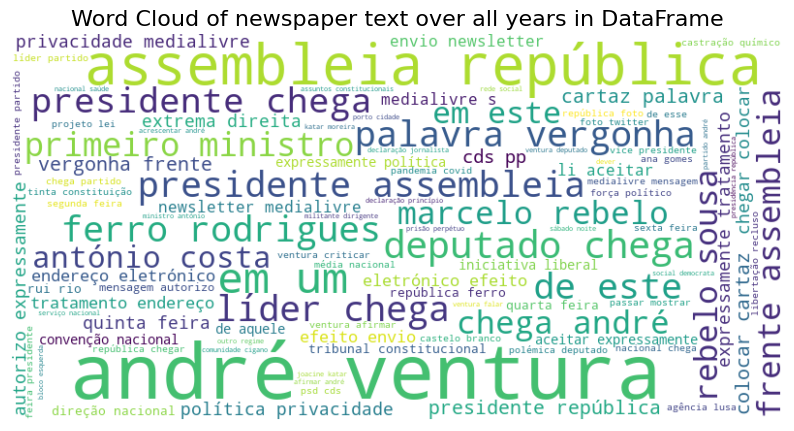

In [26]:
# Combine all text into a single string for the word cloud, is used in the other cells too
combined_text = ' '.join(df_for_visuals['Lemma_String'].dropna())  # Drop NaN values if present

# Create the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    contour_width=3,
    contour_color='steelblue'
).generate(combined_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axes
plt.title("Word Cloud of newspaper text over all years in DataFrame", fontsize=16)
# plt.savefig('/Users/hannes_seidl/Desktop/UA_Aveiro/WS24:25/FDS/FDS_project_pics/wc_all_years') # comment in and change filename if saving of the plot is necessary
plt.show()

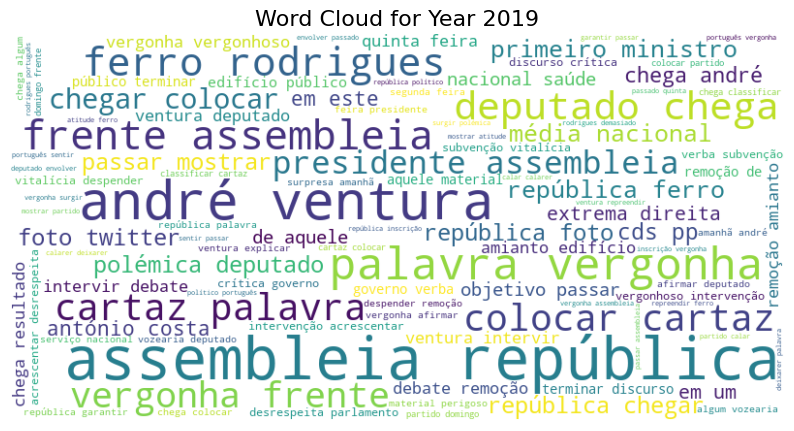

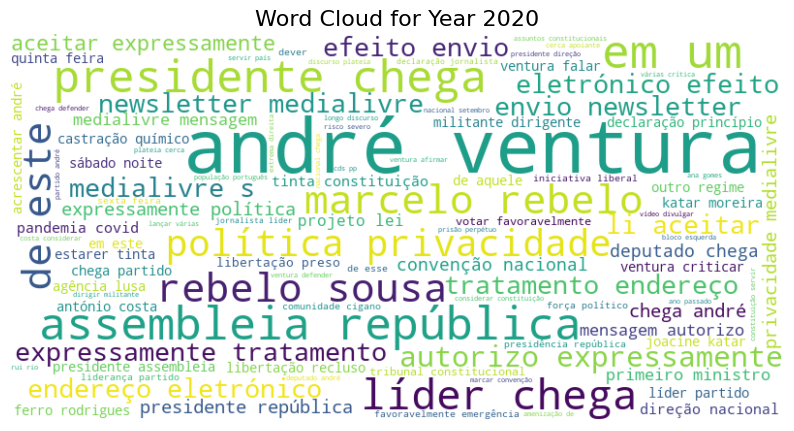

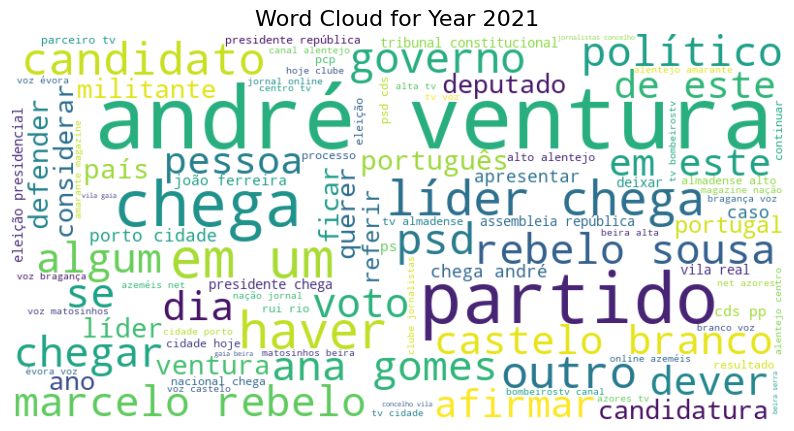

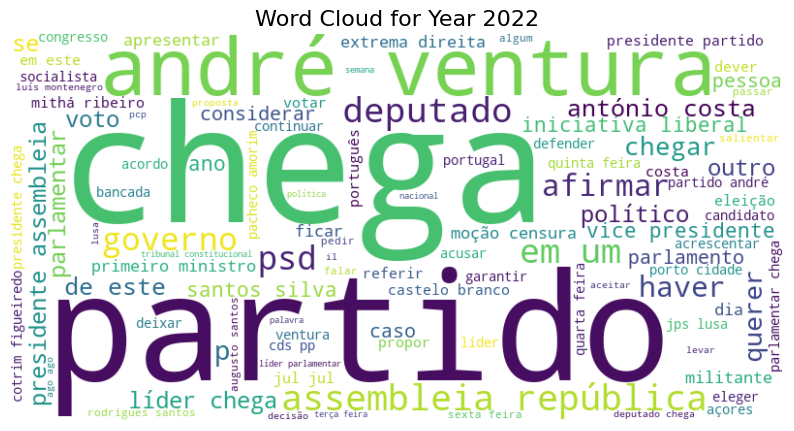

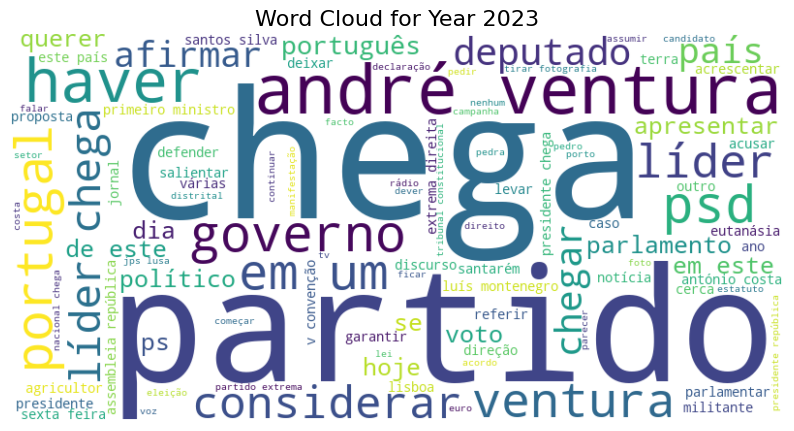

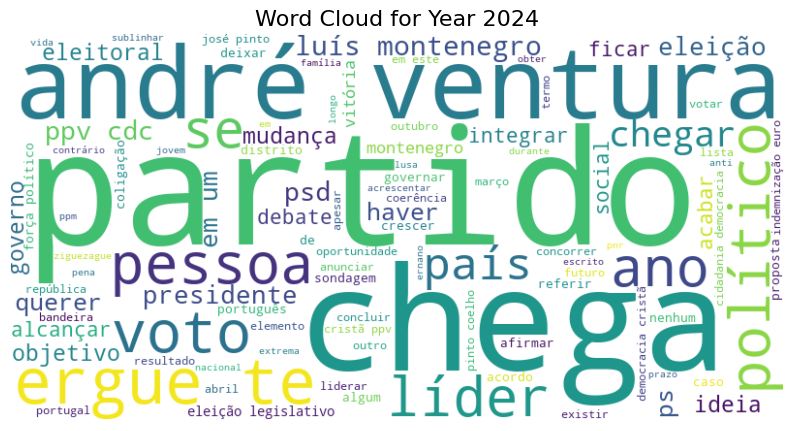

In [33]:
def generate_yearly_wordclouds(df_for_visuals, text_column='Lemma_String', timestamp_column='timestamp'):
    """
    Generate and display word clouds for each year present in the DataFrame.
    
    Parameters:
        df_for_visuals (DataFrame): The pandas DataFrame containing the data.
        text_column (str): The column containing text data for word clouds.
        timestamp_column (str): The column containing timestamps from which years are extracted.
    """
    # Extract the year from the timestamp column
    df_for_visuals['year'] = df_for_visuals[timestamp_column].astype(str).str[:4]
    
    # Sorting DataFrame by years
    df_for_visuals = df_for_visuals.sort_values('year')

    # Get unique years in the DataFrame
    unique_years = df_for_visuals['year'].unique()
    
    # Loop through each year and generate a word cloud
    for year in unique_years:
        # Filter rows for the current year
        year_df_for_visuals = df_for_visuals[df_for_visuals['year'] == year]
        
        # Combine all text for current year in string
        combined_text = ' '.join(year_df_for_visuals[text_column].dropna())

        # Generate the word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            max_words=100,
            contour_width=3,
            contour_color='steelblue'
        ).generate(combined_text)
        
        # Create filename for saving
        # filename = f"/Users/hannes_seidl/Desktop/UA_Aveiro/WS24:25/FDS/FDS_project_pics/wc_year_{year}"; # comment in and change filepath if saving of the plot is necessary


        # Plot the word cloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # Turn off axes
        plt.title(f"Word Cloud for Year {year}", fontsize=16)
        # plt.savefig(fname=filename)
        plt.show()
        
generate_yearly_wordclouds(df_for_visuals, text_column='Lemma_String', timestamp_column='timestamp')

[('chega', 6613), ('ventura', 5810), ('partido', 4931), ('andré', 4649), ('deputado', 3173), ('república', 3144), ('presidente', 3056), ('assembleia', 2377), ('em', 2044), ('haver', 2036)]


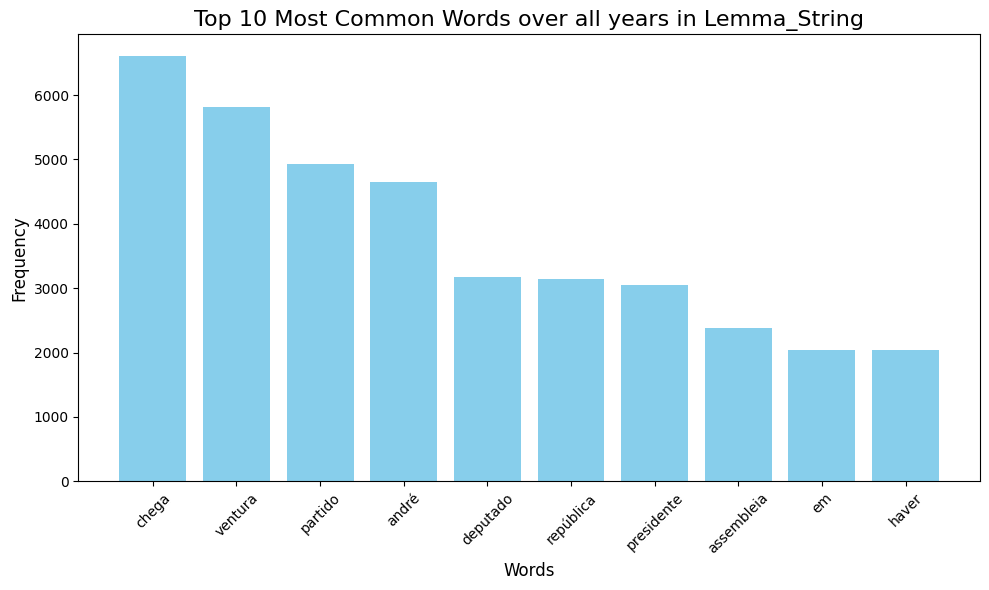

In [28]:
# Split the combined text into words
all_words = combined_text.split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the 10 most common words
most_common_words = word_counts.most_common(10)
print(most_common_words)  # Print for debugging

# Separate words and their frequencies
words, frequencies = zip(*most_common_words)

# Plot the top 10 most common words
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.title("Top 10 Most Common Words over all years in Lemma_String", fontsize=16)
plt.xlabel("Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('/Users/hannes_seidl/Desktop/UA_Aveiro/WS24:25/FDS/FDS_project_pics/most_common_words_all_years') # comment in and change filepath if saving of the plot is necessary
plt.show()

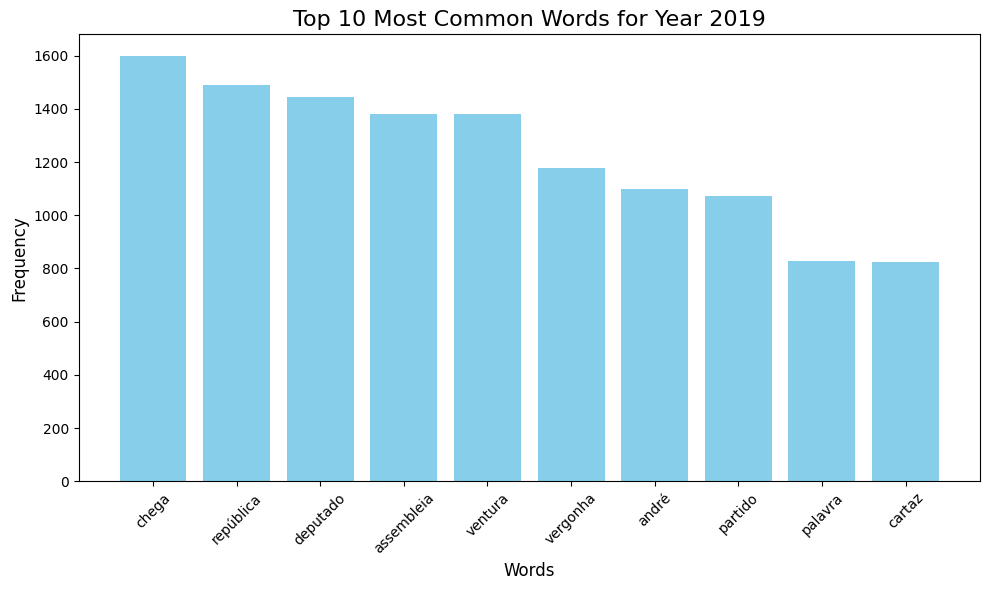

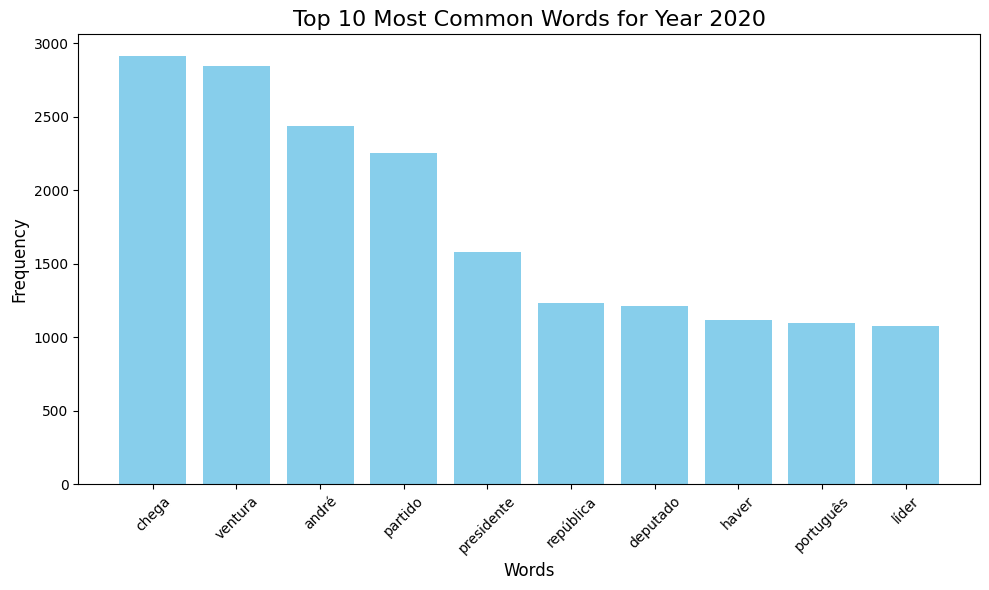

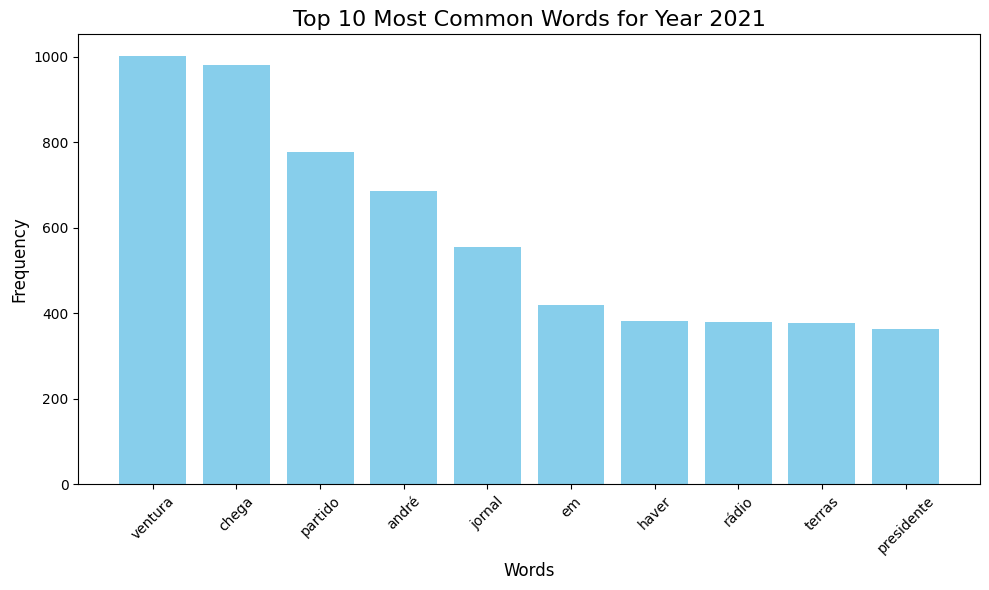

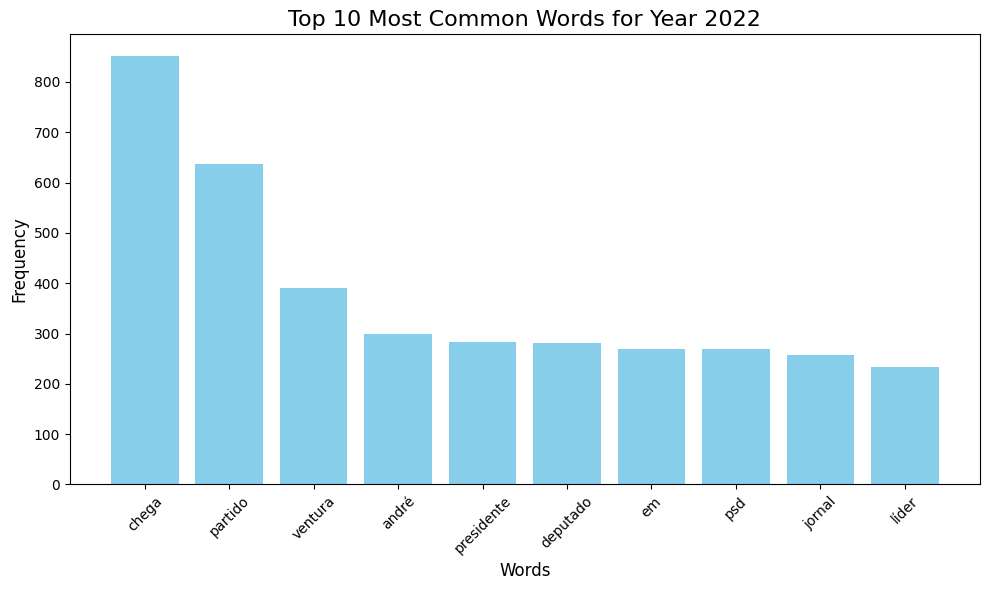

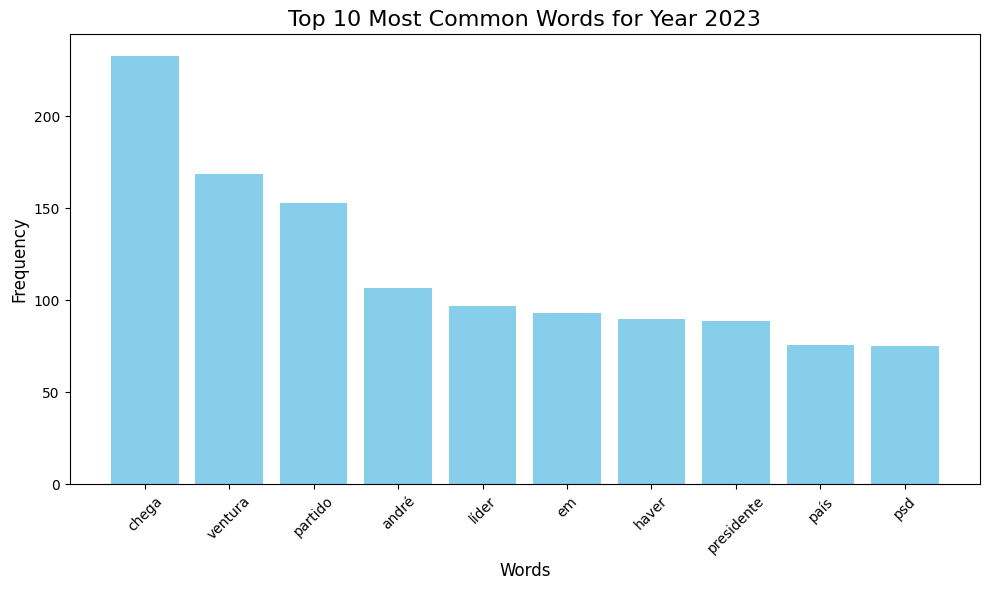

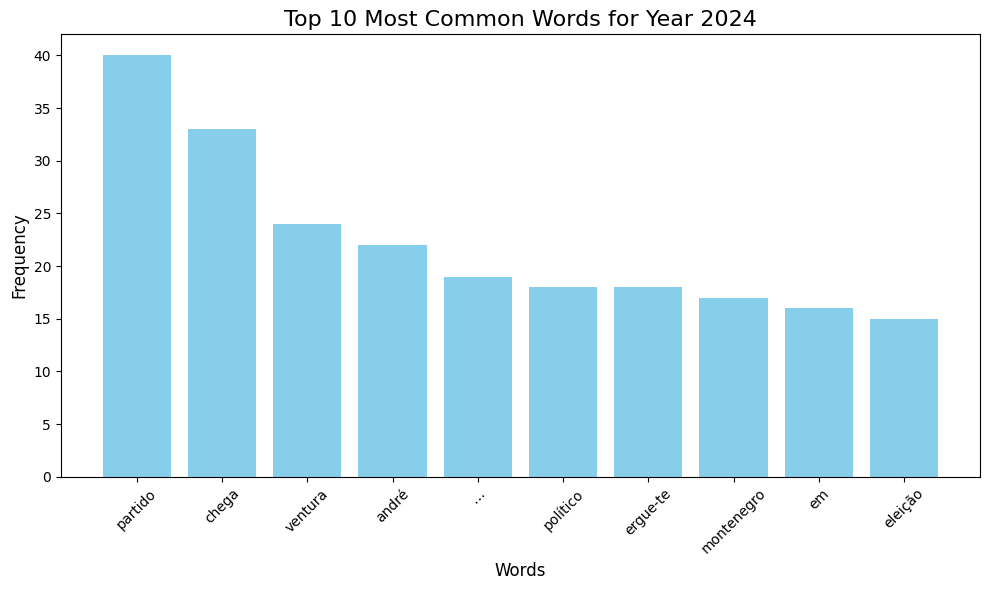

In [29]:
def plot_yearly_top_words(df_for_visuals, text_column='Lemma_String', timestamp_column='timestamp', top_n=10):
    """
    Generate bar plots of the top n most common words for each year in the DataFrame.
    
    Parameters:
        df_for_visuals (DataFrame): The pandas DataFrame containing the data.
        text_column (str): The column containing text data for analysis.
        timestamp_column (str): The column containing timestamps from which years are extracted.
        top_n (int): The number of top words to display for each year.
    """
    # Extract the year from the timestamp column
    df_for_visuals['year'] = df_for_visuals[timestamp_column].astype(str).str[:4]
    
    # Get unique years in the DataFrame
    unique_years = sorted(df_for_visuals['year'].unique())  # Ensure years are sorted
    
    # Loop through each year and generate the top words plot
    for year in unique_years:
        # Filter rows for the current year
        year_df_for_visuals = df_for_visuals[df_for_visuals['year'] == year]
        
        # Combine all text for current year in string
        combined_text = ' '.join(year_df_for_visuals[text_column].dropna())

        # Split the combined text into words
        all_words = combined_text.split()
        
        # Count the frequency of each word
        word_counts = Counter(all_words)
        
        # Get the top n most common words
        most_common_words = word_counts.most_common(top_n)
        words, frequencies = zip(*most_common_words)  # Unpack words and frequencies
        
        # Create filename for saving
        # filename = f"/Users/hannes_seidl/Desktop/UA_Aveiro/WS24:25/FDS/FDS_project_pics/most_common_words_year_{year}" # comment in and change filepath if saving of the plot is necessary

        # Plot the top n most common words
        plt.figure(figsize=(10, 6))
        plt.bar(words, frequencies, color='skyblue')
        plt.title(f"Top {top_n} Most Common Words for Year {year}", fontsize=16)
        plt.xlabel("Words", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        # plt.savefig(filename)
        plt.show()
        
plot_yearly_top_words(df_for_visuals, text_column='Lemma_String', timestamp_column='timestamp', top_n=10)

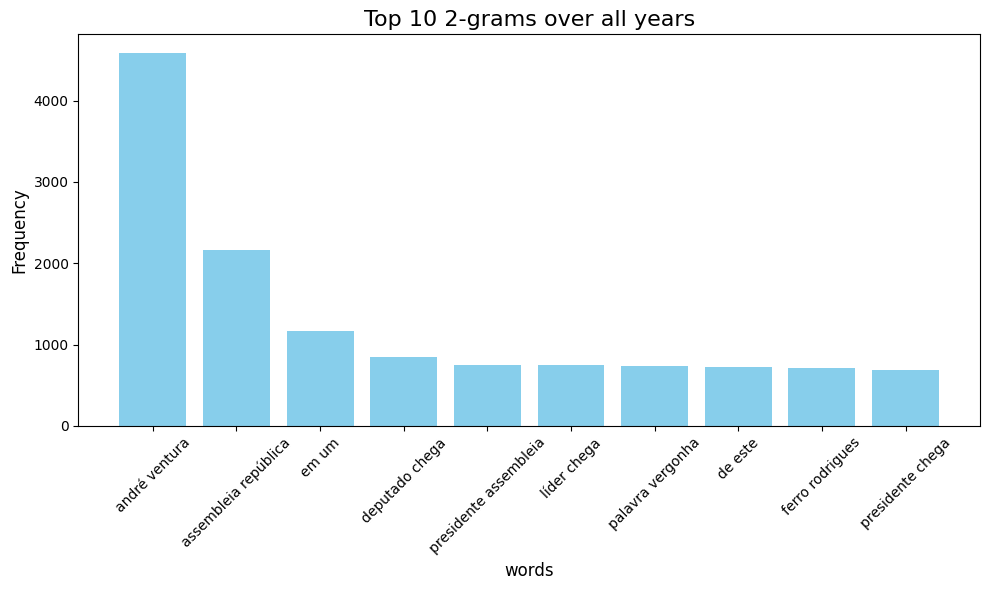

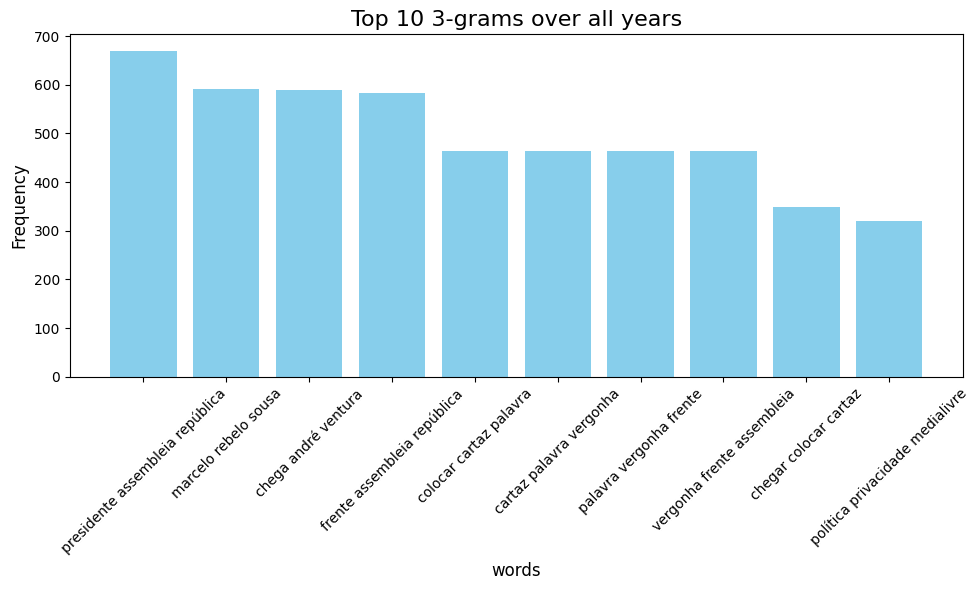

In [30]:
def plot_top_ngrams(text, ngram_range=(2, 2), top_n=10):
    """
    Generate n-grams from a combined text and plot the top n most common n-grams.
    
    Parameters:
        text (str): The combined text from which to generate n-grams.
        ngram_range (tuple): The range of n-grams to generate (e.g., (2, 2) for bigrams).
        top_n (int): The number of top n-grams to display.
    """
    # Create a CountVectorizer for the specified n-gram range
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    ngrams_matrix = vectorizer.fit_transform([text])  # Fit and transform the text
    
    # Count the occurrences of each n-gram
    ngrams_counts = ngrams_matrix.sum(axis=0)
    ngrams_freq = [(word, ngrams_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:top_n]  # Sort and get top n

    # Separate n-grams and their frequencies
    ngrams, frequencies = zip(*ngrams_freq)

    # Plot the top n most common n-grams
    plt.figure(figsize=(10, 6))
    plt.bar(ngrams, frequencies, color='skyblue')
    plt.title(f"Top {top_n} {ngram_range[0]}-grams over all years", fontsize=16)
    plt.xlabel("words", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig(f'/Users/hannes_seidl/Desktop/UA_Aveiro/WS24:25/FDS/FDS_project_pics/top_10_{ngram_range[0]}_grams_all_years')
    plt.show()

plot_top_ngrams(combined_text, ngram_range=(2, 2), top_n=10) 
plot_top_ngrams(combined_text, ngram_range=(3, 3), top_n=10)

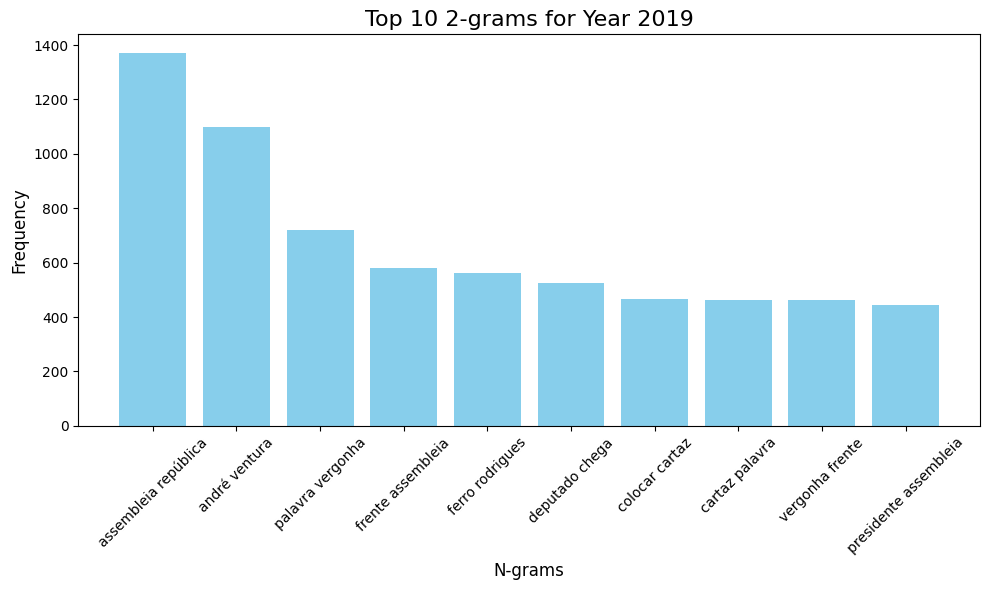

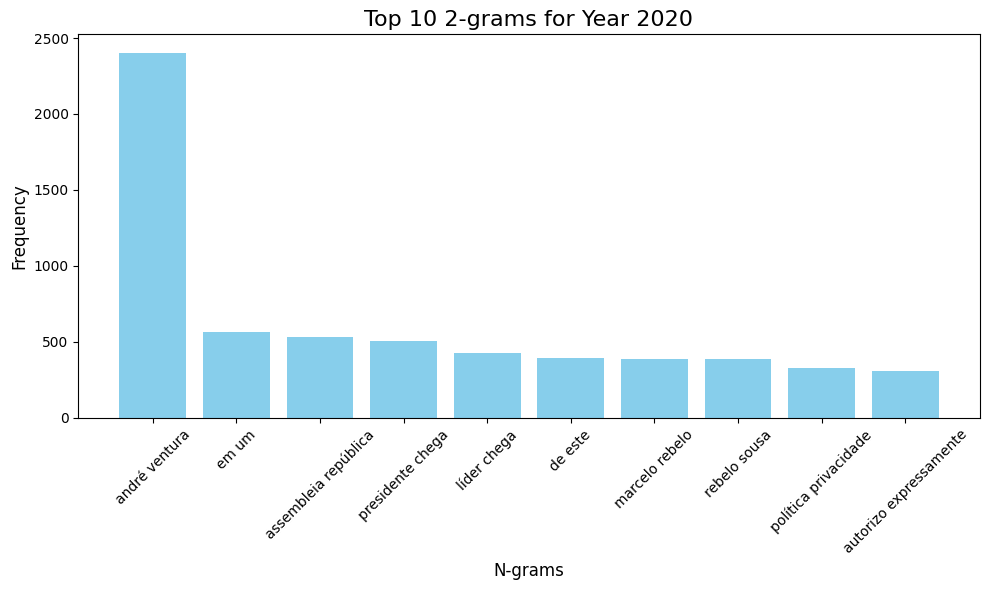

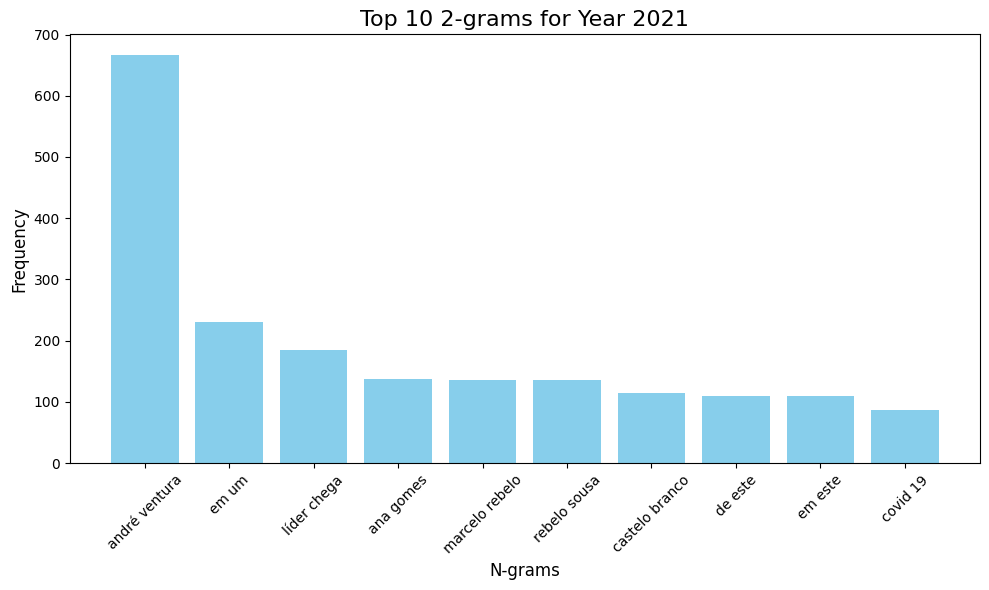

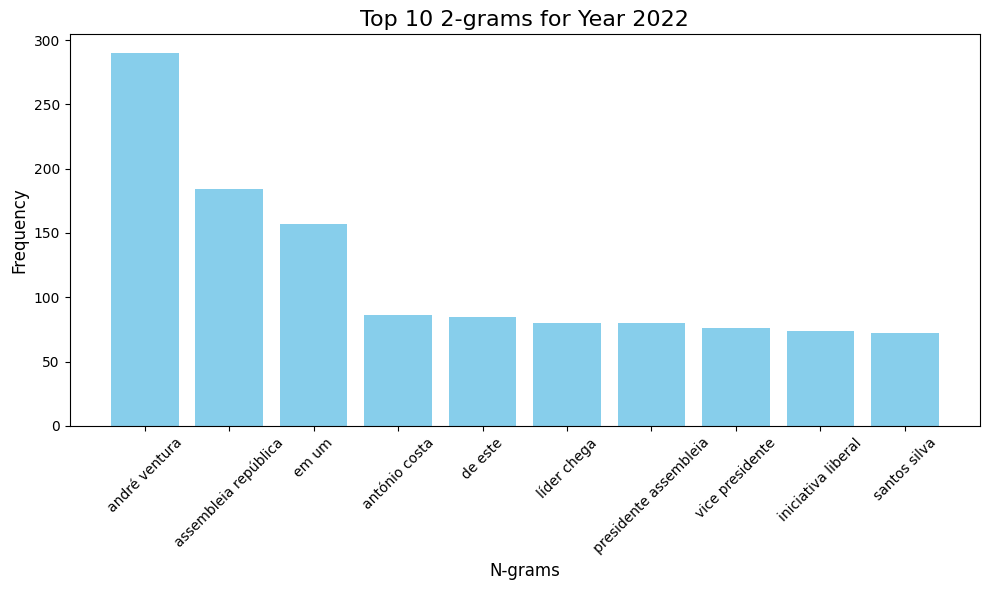

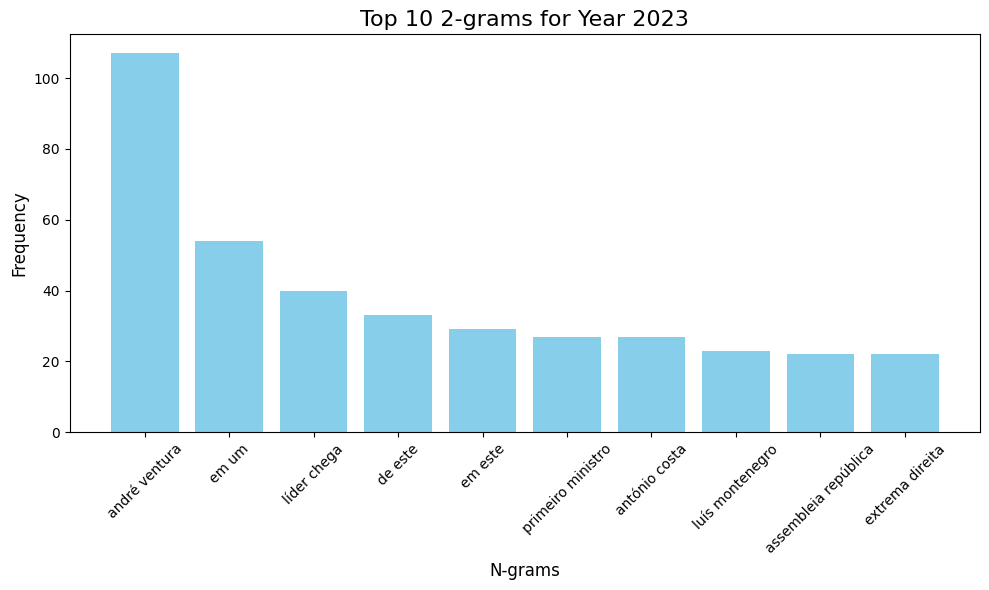

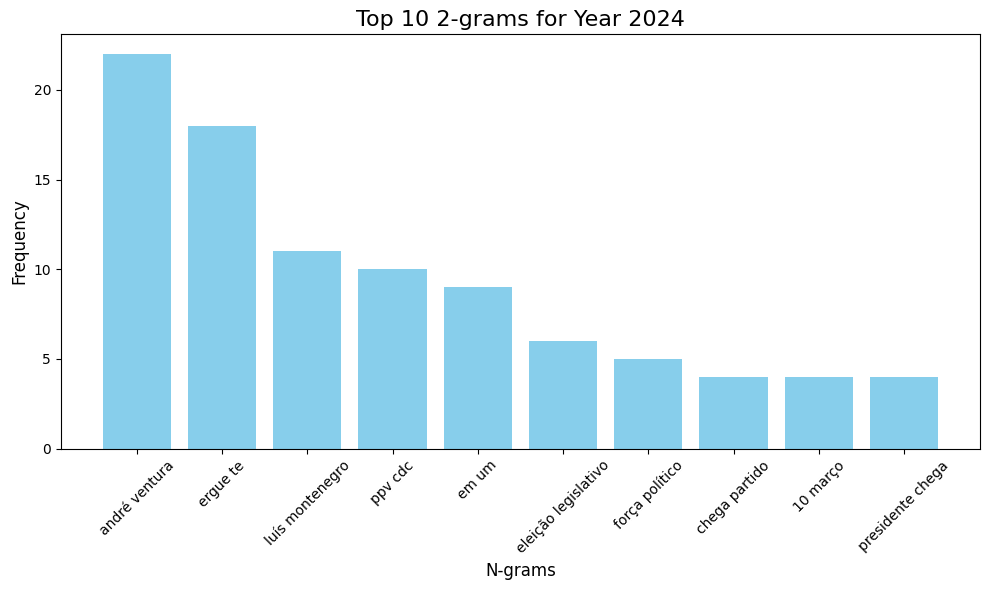

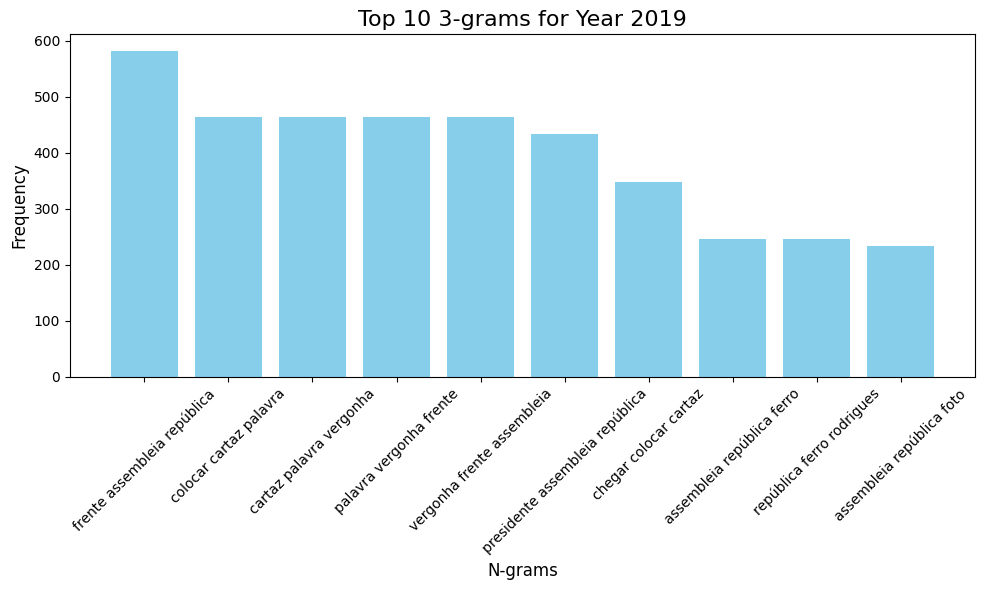

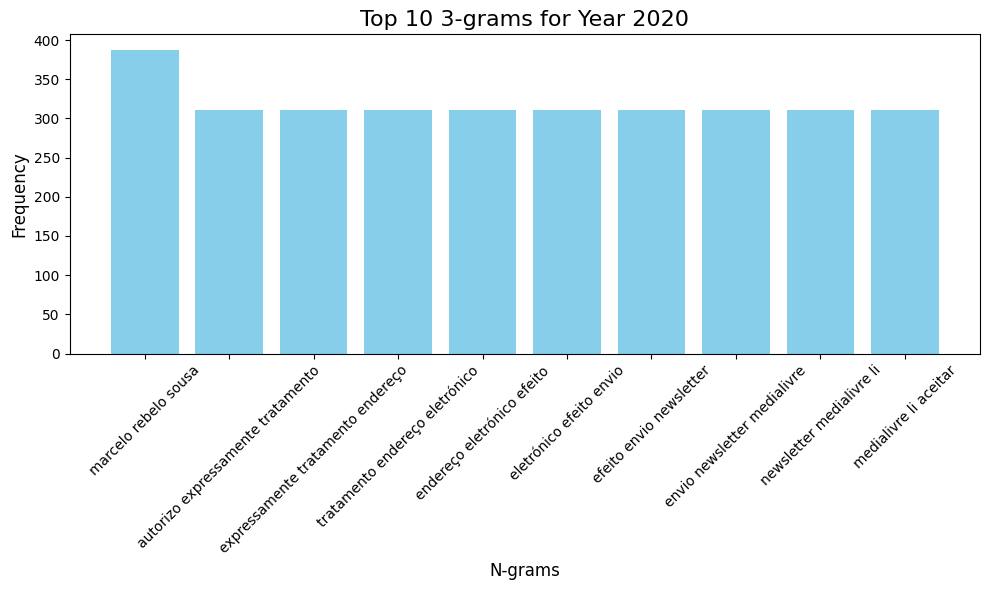

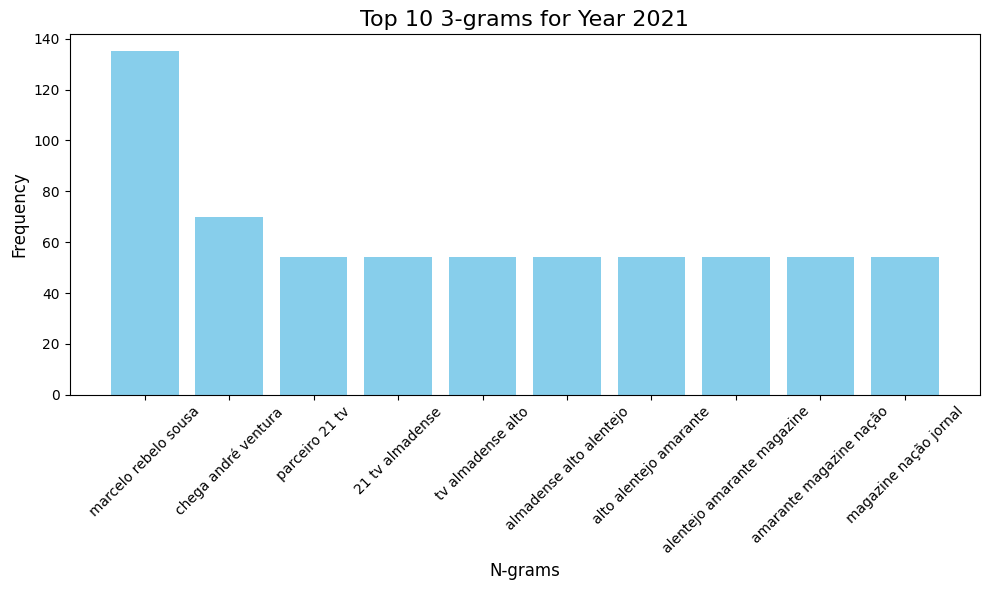

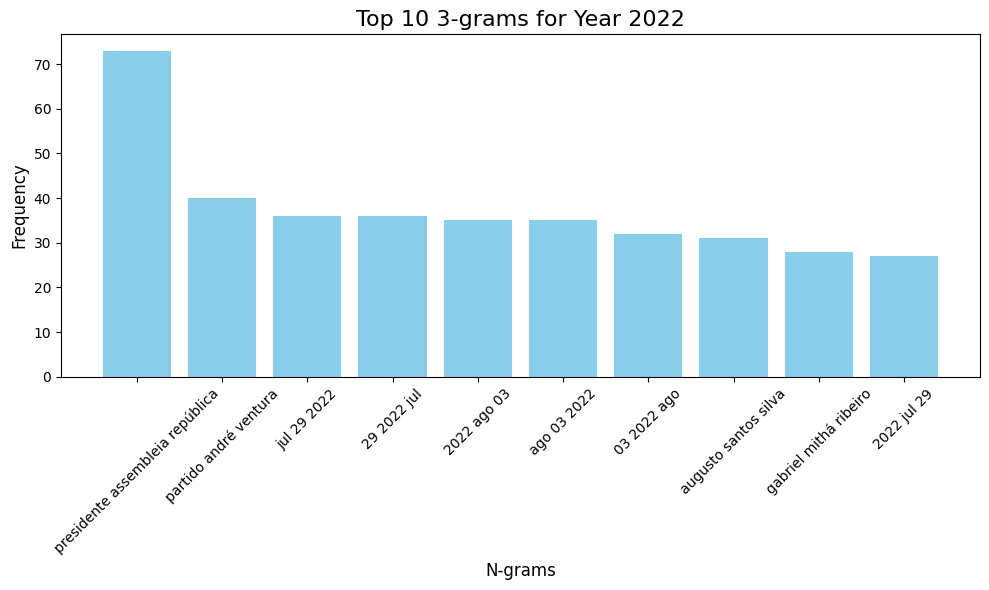

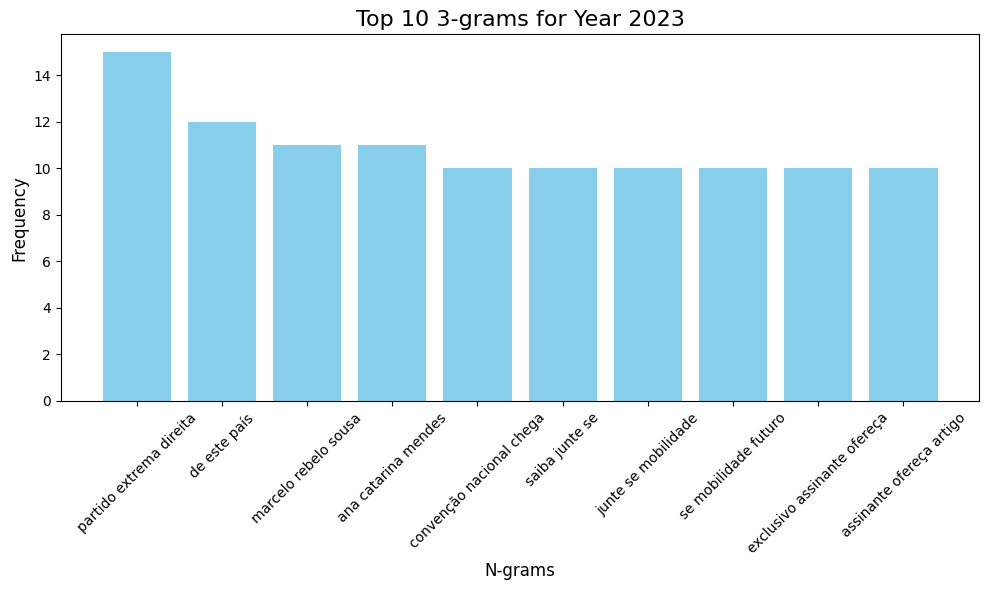

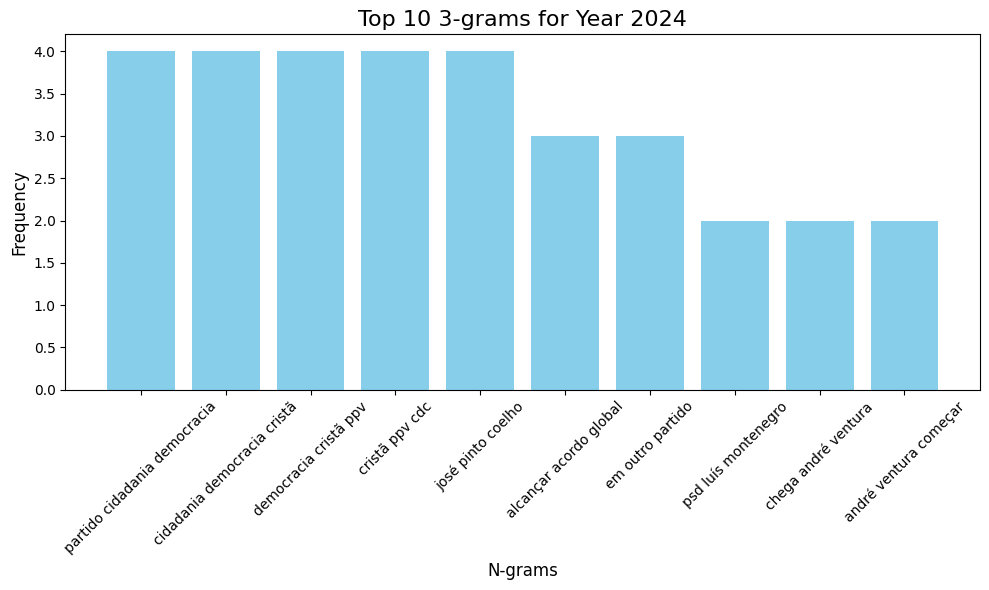

In [31]:
def plot_yearly_ngrams(df_for_visuals, text_column='Lemma_String', timestamp_column='timestamp', ngram_range=(2, 2), top_n=10):
    """
    Generate n-grams from the text column for each year in the DataFrame
    and plot the top n most common n-grams for each year.
    
    Parameters:
        df_for_visuals (DataFrame): The pandas DataFrame containing the data.
        text_column (str): The column containing text data for analysis.
        timestamp_column (str): The column containing timestamps from which years are extracted.
        ngram_range (tuple): The range of n-grams to generate (e.g., (2, 2) for bigrams).
        top_n (int): The number of top n-grams to display for each year.
    """
    # Extract the year from the timestamp column
    df_for_visuals['year'] = df_for_visuals[timestamp_column].astype(str).str[:4]
    
    # Get unique years in the DataFrame
    unique_years = sorted(df_for_visuals['year'].unique())  # Ensure years are sorted
    
    # Loop through each year and generate the top n-grams plot
    for year in unique_years:
        # Filter rows for the current year
        year_df_for_visuals = df_for_visuals[df_for_visuals['year'] == year]
        
        # Combine all text for current year in string
        combined_text = ' '.join(year_df_for_visuals[text_column].dropna())

        # Create a CountVectorizer for the specified n-gram range
        vectorizer = CountVectorizer(ngram_range=ngram_range)
        ngrams_matrix = vectorizer.fit_transform([combined_text])  # Fit and transform the text
        
        # Count the occurrences of each n-gram
        ngrams_counts = ngrams_matrix.sum(axis=0)
        ngrams_freq = [(word, ngrams_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:top_n]  # Sort and get top n

        # Create filename for saving
        # filename = f"/Users/hannes_seidl/Desktop/UA_Aveiro/WS24:25/FDS/FDS_project_pics/top_10_{ngram_range[0]}-grams_year_{year}" # c omment in and change filepath if saving of the plot is necessary

        # Separate n-grams and their frequencies
        if ngrams_freq:  # Check if there are any n-grams
            ngrams, frequencies = zip(*ngrams_freq)

            # Plot the top n most common n-grams
            plt.figure(figsize=(10, 6))
            plt.bar(ngrams, frequencies, color='skyblue')
            plt.title(f"Top {top_n} {ngram_range[0]}-grams for Year {year}", fontsize=16)
            plt.xlabel("N-grams", fontsize=12)
            plt.ylabel("Frequency", fontsize=12)
            plt.xticks(rotation=45)
            plt.tight_layout()
            # plt.savefig(filename)
            plt.show()
        else:
            print(f"No {ngram_range[0]}-grams found for year {year}.")

plot_yearly_ngrams(df_for_visuals, text_column='Lemma_String', timestamp_column='timestamp', ngram_range=(2, 2), top_n=10)  # Bigrams
plot_yearly_ngrams(df_for_visuals, text_column='Lemma_String', timestamp_column='timestamp', ngram_range=(3, 3), top_n=10)  # Trigrams